In [16]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as scp
from scipy import interpolate

In [17]:
dx = 0.05
#interior points
x,z = np.meshgrid(np.arange(0,2+dx,dx),np.arange(0,1+dx,dx))
n = x.shape[0]
m = x.shape[1]

ni = n-2
mi = m-2
xi = x[1:-1,1:-1].reshape((ni*mi,1))
zi = z[1:-1,1:-1].reshape((ni*mi,1))



xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]

xo[n:2*n,0] = x[:,-1]
zo[n:2*n,0] = z[:,-1]

xo[2*n:2*n+m-2,0] = x[0,1:-1]
zo[2*n:2*n+m-2,0] = z[0,1:-1]
xo[2*n+m-2:,0] = x[-1,1:-1]
zo[2*n+m-2:,0] = z[-1,1:-1]



In [18]:
#ordering boundary points
xo = np.zeros((n*2 + 2*(m-2),1))
zo = np.zeros((n*2 + 2*(m-2),1))
xo[0:n,0] = x[:,0]
zo[0:n,0] = z[:,0]
xo[n:n+m-2,0] = x[-1,1:-1]
zo[n:n+m-2,0] = z[-1,1:-1]
xo[n+m-2:2*n+m-2,0] = np.flipud(x[:,-1])
zo[n+m-2:2*n+m-2,0] = np.flipud(z[:,-1])
xo[2*n+m-2:,0] = np.flipud(x[0,1:-1])
zo[2*n+m-2:,0] = np.flipud(z[0,1:-1])

#print(xo)

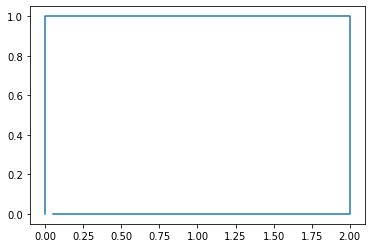

In [19]:
X = np.concatenate((xi,xo)) -1
Z = np.concatenate((zi,zo)) -1
plt.plot(xo,zo)

In [20]:
#converting into circle coordinates
#Xc = X #0.5*np.sin(X) #+X*np.sqrt(1-Z**2/2) 
#Zc = Z +np.sin(Xc*5)*0.2#Z*np.sqrt(1-X**2/2) 
Xc = X*np.sqrt(1-Z**2/2) 
Zc = Z*np.sqrt(1-X**2/2) 

xoc = Xc[ni*mi:,:]
zoc = Zc[ni*mi:,:]

#calculating boundary normals
xoc_normal = xoc*0
zoc_normal = zoc*0
xoc_normal[1:-1,0] = -zoc[2:,0]+zoc[0:-2,0]
zoc_normal[1:-1,0] = xoc[2:,0]-xoc[0:-2,0]

#boundary points
zoc_normal[0,0] = xoc[1,0] - xoc[-1,0]
xoc_normal[0,0] = -zoc[1,0] + zoc[-1,0]
zoc_normal[-1,0] = xoc[0,0] - xoc[-2,0]
xoc_normal[-1,0] = -zoc[0,0] + zoc[-2,0]


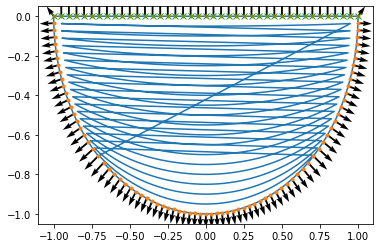

In [21]:
plt.plot(Xc,Zc)
plt.plot(xoc,zoc,'.')
plt.plot(xoc[n-1:n+m-1],zoc[n-1:n+m-1],'x')
#plt.gca().set_aspect('equal', adjustable='box')
plt.quiver(xoc,zoc,xoc_normal,zoc_normal)

In [22]:
def phi(x_i,z_i,x_j,z_j,a):
    eps = 1e-6
    r = np.sqrt((x_i-x_j)**2 + (z_i-z_j)**2)
    
    return np.exp(-(a*r)**2)

In [23]:
def nabla2(xi,zi,xj,zj,a):
    eps = 1e-6
    return 4*a**2*(a**2*(xi - xj)**2 + a**2*(zi - zj)**2 - 1)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

In [24]:
#setting up solution matrix:
interior_phi = np.zeros((mi*ni,m*n))
a = 1/dx
for i in range(0,mi*ni):
    for j in range(0,m*n):
        interior_phi[i,j] = nabla2(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)



In [25]:
#boundary conditions:
phi_BC1 = np.zeros((n-1,m*n))
phi_BC2 = np.zeros((m,m*n))
phi_BC3 = np.zeros((n-1,m*n))
phi_BC4 = np.zeros((m-2,m*n))

bc1 = np.zeros((n-1,1))
bc2 = np.zeros((m,1)) + 1
bc3 = np.zeros((n-1,1))
bc4 = np.zeros((m-2,1))

In [26]:
for i in range(0,n-1):
    for j in range(0,m*n):
        phi_BC1[i,j] = phi(xoc[i,0],zoc[i,0],Xc[j,0],Zc[j,0],a)

for i in range(0,m):
    for j in range(0,m*n):
        phi_BC2[i,j] = phi(xoc[n-1+i,0],zoc[n-1+i,0],Xc[j,0],Zc[j,0],a)

for i in range(0,n-1):
    for j in range(0,m*n):
        phi_BC3[i,j] = phi(xoc[i+m+n-1,0],zoc[i+m+n-1,0],Xc[j,0],Zc[j,0],a)

for i in range(0,m-2):
    for j in range(0,m*n):
        phi_BC4[i,j] = phi(xoc[i+m+2*n-2,0],zoc[i+m+2*n-2,0],Xc[j,0],Zc[j,0],a)


In [27]:
#reconstructing matrix

phi_mat = np.concatenate((interior_phi,phi_BC1,phi_BC2,phi_BC3,phi_BC4))


In [28]:
#constructing boundary matrix:
b_interior = np.zeros((mi*ni,1))

b_vector = np.concatenate((b_interior,bc1,bc2,bc3,bc4))

f_weights = np.linalg.solve(phi_mat,b_vector)


In [29]:
#calculating f field

phi_domain = np.zeros((n*m,n*m))
for i in range(0,n*m):
    for j in range(0,n*m):
        phi_domain[i,j] = phi(Xc[i,0],Zc[i,0],Xc[j,0],Zc[j,0],a)

f_field = np.matmul(phi_domain,f_weights)



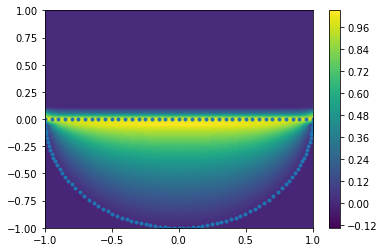

In [30]:
#interpolating data:
ds = 0.05
x_int, z_int = np.meshgrid(np.arange(-1,1+ds,0.05),np.arange(-1,1+ds,0.05))
m_cart = x_int.shape[0]
n_cart = x_int.shape[1]
x_cart = x_int.reshape((m_cart*n_cart,1))
z_cart = z_int.reshape((m_cart*n_cart,1))

#generating cartesian phi
phi_cartesian = np.zeros((m_cart*n_cart,m*n))
for i in range(0,m_cart*n_cart):
    for j in range(0,m*n):
        phi_cartesian[i,j] = phi(x_cart[i,0],z_cart[i,0],Xc[j,0],Zc[j,0],a)

f_cartesian = np.matmul(phi_cartesian,f_weights).reshape((m_cart,n_cart))
plt.contourf(x_int, z_int,f_cartesian,levels=100)
plt.colorbar()
plt.plot(xoc,zoc,'.')
